In [2]:
%pylab inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


14
13
12
[array([[0. , 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]]), array([[0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5],
       [1. , 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]]), array([[0.5, 0.5, 0.5],
       [0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0. , 0.5, 0.5],
       [0.5, 0. , 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]]), array([[0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],


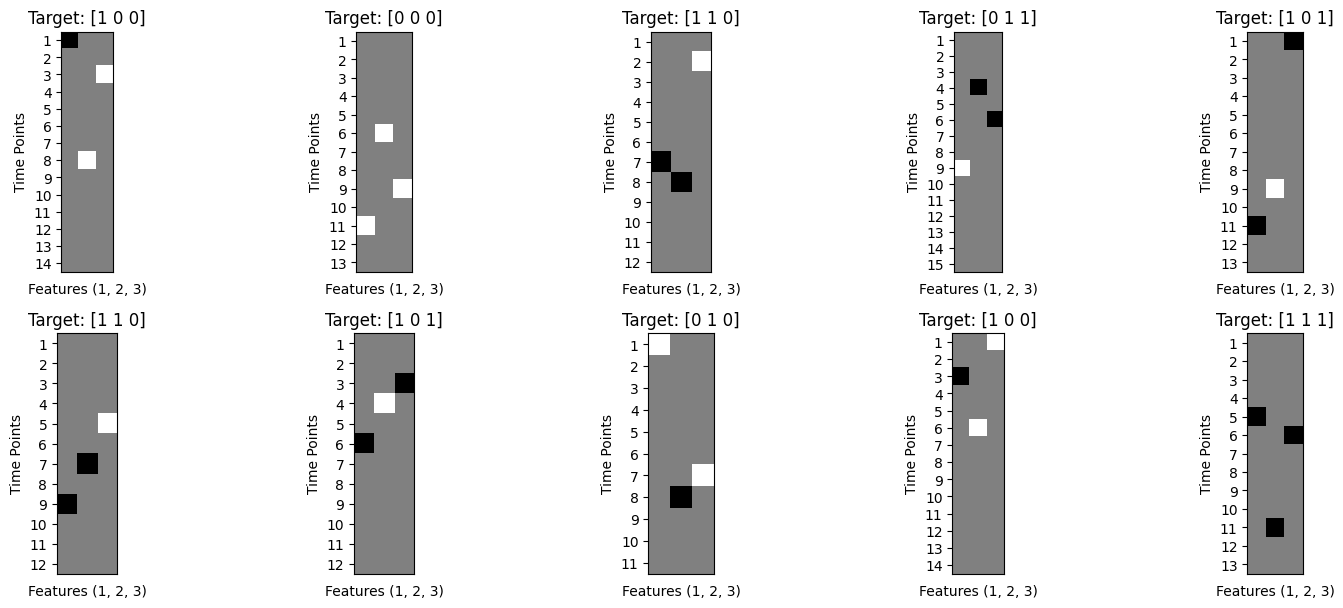

In [6]:
import numpy


def generateTrainData(
    samples, noise, delayRange, baseTPS=[0, 1, 2, 3, 4], conceptNoise=[0.0, 0.0, 0.0]
):
    # Initialize lists to store the sequences and their corresponding targets.
    sequences = []
    targets = []

    # Loop to generate the specified number of samples.
    for _ in range(samples):
        # Randomly select three unique time points from baseTPS for concept encoding.
        tps = numpy.random.choice(baseTPS, 3, replace=False)
        # Randomly choose a binary concept for each of the three features.
        concept = numpy.random.choice([0, 1], 3)
        # Initialize the sequence with a baseline value and add a random delay.
        seq = numpy.zeros((len(baseTPS) + numpy.random.choice(delayRange), 3)) + 0.5

        # Loop through each selected time point and encode the concept.
        for i, tp in enumerate(tps):
            # Check if concept noise should be applied.
            if numpy.random.random() < conceptNoise[i]:
                # Retain the baseline value if concept noise is applied.
                V = seq[tp]
            else:
                # Set the concept at the time point: 1.0 or 0.0 adjusted by 0.5.
                V = numpy.array([0.5, 0.5, 0.5])
                V[i] = 1.0 if concept[i] == 0 else 0.0
            # Assign the concept values to the sequence at the chosen time point.
            seq[tp] = V

        # Add Gaussian noise to the entire sequence.
        seq += numpy.random.normal(0.0, noise, seq.shape)
        # Ensure the sequence values are within the range [0.0, 1.0].
        seq = numpy.clip(seq, 0.0, 1.0)
        # Append the generated sequence and its target concept to the lists.
        sequences.append(seq)
        targets.append(concept)

    # Return the list of sequences and the numpy array of targets.
    return sequences, numpy.array(targets)


# Example usage of the function:
# Generate 10 sequences with a specific noise level and delay range.
s, t = generateTrainData(
    10, 0.0, [1, 2, 3, 4, 5], baseTPS=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
)
print(len(s[0]))
print(len(s[1]))
print(len(s[2]))
print(s)

print(t)

# Plotting the sequences with detailed time points on the Y-axis
plt.figure(figsize=(15, 15))  # Increased figure size for better visibility

for i in range(len(s)):
    ax = plt.subplot(5, 5, i + 1)
    im = ax.imshow(s[i], cmap="gray", vmin=0.0, vmax=1.0)
    plt.title(f"Target: {t[i]}")

    # Setting labels for features (X-axis) and detailed time points (Y-axis)
    plt.xlabel("Features (1, 2, 3)")
    plt.ylabel("Time Points")

    # Setting tick marks for each time point on the Y-axis
    ax.set_yticks(range(s[i].shape[0]))
    ax.set_yticklabels([f"{j+1}" for j in range(s[i].shape[0])])

    # Removing X-axis tick marks
    plt.xticks([])

plt.tight_layout()
plt.show()

In [35]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, rnn_output):
        attn_weights = F.softmax(self.attention(rnn_output), dim=1)
        context = attn_weights * rnn_output
        context = context.sum(1)
        return context


class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.outputLayer = nn.Linear(hidden_dim, 3)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim)
        rnn_out, _ = self.rnnLayer(x, h0)
        rnn_out = torch.tanh(rnn_out)
        attn_out = self.attention(rnn_out)
        out = torch.sigmoid(self.outputLayer(attn_out))
        return out

    def resetHidden(self):
        self.hidden = list()

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.rnnLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
        return numpy.array(O), numpy.array(H)

In [41]:
model = NetRNNWithAttention(hidden_dim=12, inp=3)
s, t = generateTrainData(100, 0.1, [5])
output = model(torch.Tensor(s))
print(output.shape)
print(model)

torch.Size([100, 3])
NetRNNWithAttention(
  (rnnLayer): RNN(3, 12, batch_first=True)
  (attention): Attention(
    (attention): Linear(in_features=12, out_features=12, bias=True)
  )
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)


In [42]:
numpy.round([0, 0.5, 1.0], 1)

array([0. , 0.5, 1. ])

In [43]:
error = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
collectorA = dict()
for cond, td in enumerate([[1, 2, 3, 4, 5], [1], [2], [3], [4], [5]]):
    # if cond>3:
    if True:
        for rep in range(20):
            for kind in ["RNN"]:
                if kind == "RNN":
                    model = NetRNNWithAttention(hidden_dim=12)
                optimizer = optim.Adam(model.parameters())
                error = nn.MSELoss()
                acc = 0.0
                W = []
                A = []
                while acc < 0.97:
                    model.resetHidden()
                    s, t = generateTrainData(
                        100, 0.05, td, baseTPS=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                    )
                    s = numpy.array(s)  # Convert to numpy array
                    divs = []
                    for i in range(
                        s.shape[0]
                    ):  # use 64 when training for single delayRange
                        optimizer.zero_grad()
                        output = model(
                            torch.Tensor(s[i].reshape(1, s[i].shape[0], 3))
                        )  # shape greater than 8
                        loss = error(output, torch.Tensor(t[i]))
                        loss.backward()
                        optimizer.step()
                        div = output.detach().numpy().reshape(t[i].shape) - t[i]
                        divs.append(1.0 - abs(div).mean())
                    W.append(loss.item())
                    acc = mean(divs)
                    A.append(acc)
                    # print(len(W),acc)
                    if acc < 0.97 and len(A) > 2000:
                        if kind == "RNN":
                            model = NetRNNWithAttention(hidden_dim=12)
                        optimizer = optim.Adam(model.parameters())
                        error = nn.MSELoss()
                        acc = 0.0
                        W = []
                        A = []
                        print("repeat")
                # collectorA["{0} {1} {2}".format(kind,cond,rep)]=A
                # torch.save(model,"modelsLongDelay/model_{0}_{1}_{2}.model".format(kind,cond,rep))
                print("{0} {1} {2}".format(kind, cond, rep), len(A))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_11943/2207355704.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s = numpy.array(s)  # Convert to numpy array
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNN 0 0 166
RNN 0 1 156
RNN 0 2 144
RNN 0 3 140
RNN 0 4 147
RNN 0 5 125
RNN 0 6 128
RNN 0 7 177
RNN 0 8 122
RNN 0 9 184
RNN 0 10 206
RNN 0 11 122
RNN 0 12 144
RNN 0 13 156
RNN 0 14 141
RNN 0 15 170
RNN 0 16 121
RNN 0 17 151
RNN 0 18 142
RNN 0 19 134
RNN 1 0 165
RNN 1 1 151
RNN 1 2 122
RNN 1 3 130
RNN 1 4 155
RNN 1 5 202
RNN 1 6 122
RNN 1 7 138
RNN 1 8 163
RNN 1 9 120
RNN 1 10 198
RNN 1 11 159
RNN 1 12 132
RNN 1 13 139
RNN 1 14 120
RNN 1 15 135
RNN 1 16 154
RNN 1 17 155
RNN 1 18 116
RNN 1 19 170
RNN 2 0 163
RNN 2 1 161
RNN 2 2 163
RNN 2 3 128
RNN 2 4 171
RNN 2 5 160
RNN 2 6 156
RNN 2 7 120
RNN 2 8 124
RNN 2 9 129
RNN 2 10 156
RNN 2 11 176
RNN 2 12 197
RNN 2 13 125
RNN 2 14 126
RNN 2 15 213
RNN 2 16 125
RNN 2 17 217
RNN 2 18 168
RNN 2 19 151
RNN 3 0 172
RNN 3 1 154
RNN 3 2 209
RNN 3 3 194
RNN 3 4 128
RNN 3 5 149
RNN 3 6 157
RNN 3 7 132
RNN 3 8 172
RNN 3 9 154
RNN 3 10 214
RNN 3 11 144
RNN 3 12 151
RNN 3 13 182
RNN 3 14 150
RNN 3 15 165
RNN 3 16 118
RNN 3 17 141
RNN 3 18 138
RNN 3 19 165
